# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we coveredc transfer learning feature extraction. Now it's time to learn about fine-tuning.

In [2]:
!nvidia-smi

Tue Jan 10 23:18:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.92.01    Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0  On |                  N/A |
|  0%   32C    P8    35W / 350W |    457MiB / 24576MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating help functions

Let's build helper functions instead of rewriting them in each notebook.

In [3]:
# download the helper functions file in the TensorFlow Developer certification GitHub repo
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

2023-01-10 23:18:24.926285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 23:18:25.706638: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-01-10 23:18:25.706689: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-01-10 23:18:25.708798: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-01-10 23:18:25.965896: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


### Let's get some data...

This time we're going to see how we can use the pretrained in-built models via `tf.keras.applications` and apply them to our own problem of recognizing images of food.

Source: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of Food101
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

# Manually moved extracted folder into ../data/

In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("../data/10_food_classes_10_percent")

There are 2 directories and 0 images in '../data/10_food_classes_10_percent'.
There are 10 directories and 0 images in '../data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '../data/10_food_classes_10_pe

In [7]:
# create training and test directory paths
train_dir = "../data/10_food_classes_10_percent/train"
test_dir = "../data/10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

IMG_SIZE=(224, 224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.


2023-01-10 23:18:26.713253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 23:18:26.714738: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3090)
2023-01-10 23:18:26.832065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:18:26.832099: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2023-01-10 23:18:26.832114: I tensorflow/core/common_runtime/pluggable_device/

Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out class names of dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# see example of a batch of data -- commented below to save space
# for images, labels in train_data_10_percent.take(1):
#     print(images, labels)

## Model 0: Building a transfer learning model using the Keras Fucntional API

The sequential API runs thing sequentially and is straight forward.

The functional API is more flexible.

In [12]:
# 1. Create tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # We're removing the "top" layer/output layer, because we're going to modify to fit our use case of 10 classes

# 2. Freeze the base model so the underlying weights are changed from the original model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="Input Layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) # always check if the input was normalized on the original model

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pool_layers")(x)
print(f"Shape after globalaveragepooling2d: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",  experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after globalaveragepooling2d: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230110-231829
Epoch 1/5


2023-01-10 23:18:32.002034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:18:32.400120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:18:32.400171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:18:32.400221: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:18:32.401856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

24/24 [==============================] - ETA: 0s - loss: 1.8431 - accuracy: 0.4533

2023-01-10 23:18:38.592656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:18:38.962254: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:18:38.962317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:18:38.962354: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:18:38.962917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

24/24 [==============================] - 10s 151ms/step - loss: 1.8431 - accuracy: 0.4533 - val_loss: 1.2898 - val_accuracy: 0.7368
Epoch 2/5
24/24 [==============================] - 2s 64ms/step - loss: 1.0665 - accuracy: 0.7760 - val_loss: 0.8775 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 2s 64ms/step - loss: 0.7761 - accuracy: 0.8213 - val_loss: 0.7281 - val_accuracy: 0.8273
Epoch 4/5
24/24 [==============================] - 2s 63ms/step - loss: 0.6250 - accuracy: 0.8533 - val_loss: 0.6121 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 2s 63ms/step - loss: 0.5397 - accuracy: 0.8773 - val_loss: 0.5601 - val_accuracy: 0.8750


In [13]:
# evaluate on the full data set
model_0.evaluate(test_data)

79/79 [==============================] - 4s 46ms/step - loss: 0.5534 - accuracy: 0.8640


[0.5533630847930908, 0.8640000224113464]

In [14]:
 # check the layers in our base model (efficient_net)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [15]:
# summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pool_layers   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


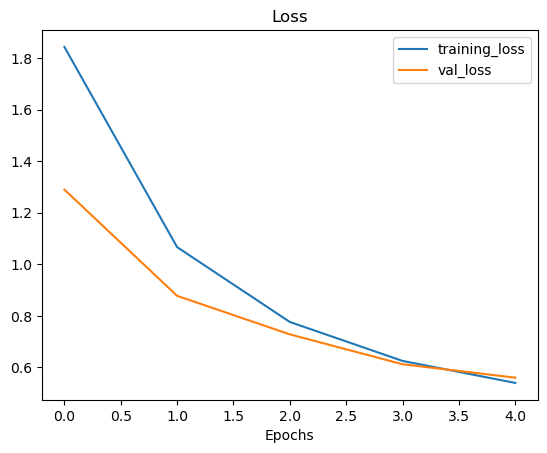

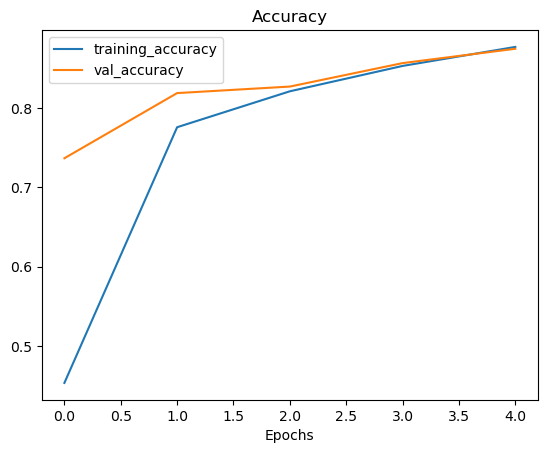

In [17]:
# check out loss curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a train model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then when it passes through the GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to a GlobalAveragePooling2D layer.

In [18]:
# Define input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}")

# Pass the random tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled tensor:\n {global_average_pooled_tensor}")

# check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274686  -0.8426257   0.31943342]
   [-1.4075519  -2.3880594  -1.039248  ]
   [-0.55732316  0.53970677  1.6994323 ]
   [ 0.28893653 -1.5066113  -0.26454788]]

  [[-0.59722424 -1.9171128  -0.62044096]
   [ 0.8504024  -0.40604675 -3.025841  ]
   [ 0.9058464   0.29855967 -0.2256155 ]
   [-0.76164424 -1.8917137  -0.9384714 ]]

  [[ 0.778522   -0.4733888   0.97772676]
   [ 0.24694404  0.20573732 -0.52562314]
   [ 0.32410017  0.02545412 -0.10638462]
   [-0.63694745  1.160312    0.25073585]]

  [[-0.41728505  0.40125757 -1.4145439 ]
   [-0.59318614 -1.6617215   0.335671  ]
   [ 0.10815619  0.2347966  -0.5666874 ]
   [-0.3581984   0.8869861   0.52744746]]]]
2D global average pooled tensor:
 [[-0.09368651 -0.45840436 -0.28855982]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [19]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368651, -0.45840436, -0.28855982]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the results of transfer learning when using 10% of the training data, how about 1%? Let's set up experiments to find out.

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with the data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning with 100% of the training data with data augmentation

> Always use the same dataset when comparing models.

### Getting and preprocessing data for `model_1`

In [20]:
# Download an unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")
!mv "10_food_classes_1_percent" "../data/10_food_classes_1_percent"

--2023-01-10 23:18:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.32.240, 142.251.45.48, 142.251.45.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.32.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  57.8MB/s    in 2.2s    

2023-01-10 23:18:53 (57.8 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]

mv: cannot move '10_food_classes_1_percent' to '../data/10_food_classes_1_percent/10_food_classes_1_percent': Directory not empty


In [21]:
# create training and test dirs
train_dir_1_percent = "../data/10_food_classes_1_percent/train"
test_dir = "../data/10_food_classes_1_percent/test"

In [22]:
walk_through_dir("../data/10_food_classes_1_percent")

There are 3 directories and 0 images in '../data/10_food_classes_1_percent'.
There are 10 directories and 0 images in '../data/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test/

In [23]:
# set up data loaders
IMG_SIZE=(224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

Including preprocessing in the layers of the model, the benefits are:
* Preprocessing of images happens on the GPU
* Image data augmentation only happens during the training, we can export our whole model and use it elsewhere

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation - manipulating the images with rotation, shifts, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # keep model like resnet50V2 but efficient net has rescaling built in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

Text(0.5, 1.0, 'original random image from class steak')

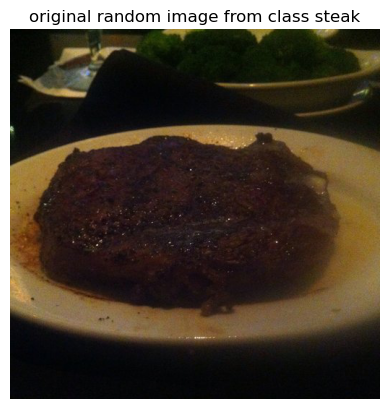

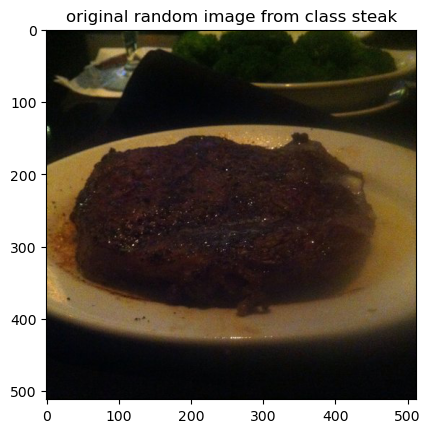

In [25]:
# View a random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "../data/10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image


# read in random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"original random image from class {target_class}")
plt.axis(False)

# plot augmented image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img) / 255.)
plt.title(f"original random image from class {target_class}")

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [26]:
# Set up the input shape and base model, freeze base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # removing the top layer to add our own Dense layer
base_model.trainable=False

# create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs after augmentation and don't train it
x = base_model(x, training=False)

# pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=(0.25 * len(test_data)),
                                # track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230110-231857
Epoch 1/5


2023-01-10 23:19:00.550515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:19:01.233914: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:19:01.233981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:19:01.234010: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:19:01.234661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

3/3 [==============================] - ETA: 0s - loss: 2.4772 - accuracy: 0.0714

2023-01-10 23:19:04.527188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:19:04.861104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:19:04.861156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:19:04.861204: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:19:04.861806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

3/3 [==============================] - 8s 1s/step - loss: 2.4772 - accuracy: 0.0714 - val_loss: 2.2812 - val_accuracy: 0.1219
Epoch 2/5
3/3 [==============================] - 3s 932ms/step - loss: 2.1861 - accuracy: 0.2000 - val_loss: 2.1482 - val_accuracy: 0.2078
Epoch 3/5
3/3 [==============================] - 2s 839ms/step - loss: 1.9502 - accuracy: 0.3429 - val_loss: 2.0089 - val_accuracy: 0.3391
Epoch 4/5
3/3 [==============================] - 2s 789ms/step - loss: 1.7621 - accuracy: 0.5857 - val_loss: 1.9163 - val_accuracy: 0.4094
Epoch 5/5
3/3 [==============================] - 2s 799ms/step - loss: 1.6391 - accuracy: 0.6429 - val_loss: 1.8015 - val_accuracy: 0.4859


In [27]:
# evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 3s 32ms/step - loss: 1.8064 - accuracy: 0.4712


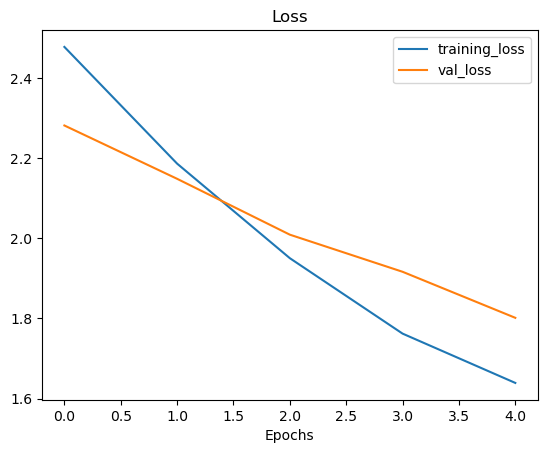

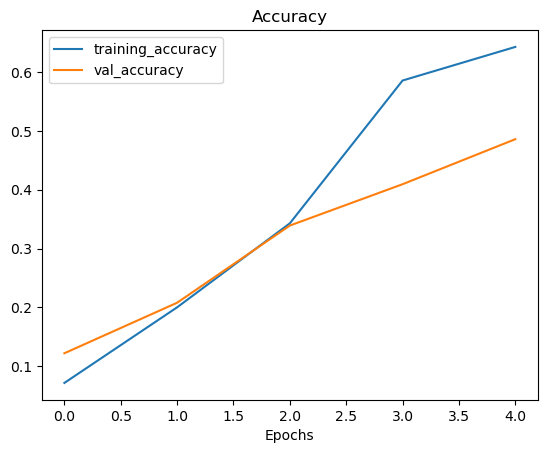

In [28]:
# loss curves with data augmentation, 1% of the data
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of the data and data augmentation

In [29]:
# set up directories

train_dir_10_percent = "../data/10_food_classes_10_percent/train"
test_dir = "../data/10_food_classes_10_percent/test"

In [30]:
# set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # EfficientNet has a rescaling layer built in
], name="data_augmentation")
    
# set up the input shape to our model
input_shape = (224, 224, 3)

# create a frozen base model, also called the backbone
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create the inputs and outputs
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # we pass the augmented images to the base model but keep the model in inference mode, also ensures batch norm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Creating a model checkpoint callback

The model checkpoint callback intermediately saves our model during the training. Lets you restart where you left off.

In [32]:
# Set checkpoint path
checkpoint_path = "../models/ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch", # save every epoch
                                                        verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [33]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                                                 checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230110-231920
Epoch 1/5


2023-01-10 23:19:24.078826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:19:24.743336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:19:24.743421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:19:24.743475: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:19:24.744396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

24/24 [==============================] - ETA: 0s - loss: 2.0363 - accuracy: 0.3373

2023-01-10 23:19:45.973012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:19:46.331039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:19:46.331088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:19:46.331115: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:19:46.331718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi


Epoch 1: saving model to ../models/ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 27s 947ms/step - loss: 2.0363 - accuracy: 0.3373 - val_loss: 1.4825 - val_accuracy: 0.6497
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3330 - accuracy: 0.6787
Epoch 2: saving model to ../models/ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 925ms/step - loss: 1.3330 - accuracy: 0.6787 - val_loss: 1.0044 - val_accuracy: 0.7714
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0281 - accuracy: 0.7667
Epoch 3: saving model to ../models/ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 928ms/step - loss: 1.0281 - accuracy: 0.7667 - val_loss: 0.8015 - val_accuracy: 0.8141
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8410 - accuracy: 0.7920
Epoch 4: saving model to ../models/ten_percent_model_chec

In [34]:
results_10_percent_aug_data = model_2.evaluate(test_data)

79/79 [==============================] - 3s 33ms/step - loss: 0.6305 - accuracy: 0.8512


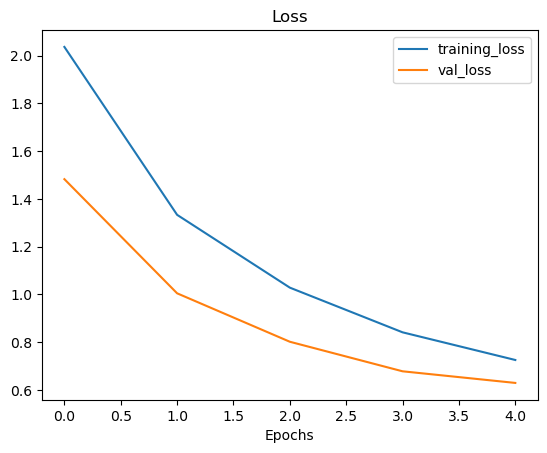

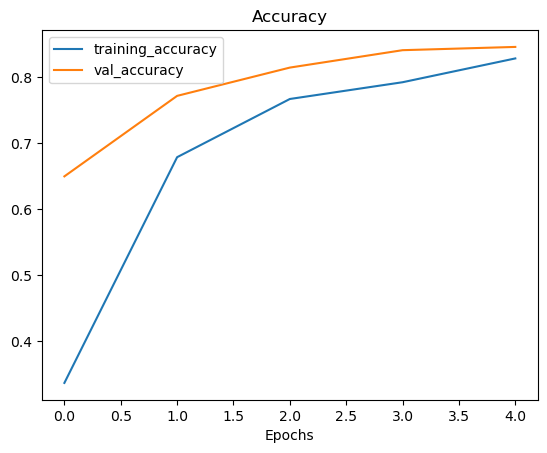

In [35]:
# plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### loading in checkpoint weights

Loading in checkpointed weights reutrns a model to a specific checkpoint

In [36]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [37]:
# evaluate model 2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 3s 33ms/step - loss: 0.6305 - accuracy: 0.8512


In [38]:
# If the results match then it worked
results_10_percent_aug_data == loaded_weights_model_results

True

In [39]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_aug_data), np.array(loaded_weights_model_results))

array([ True,  True])

## Model 3: Fine-tuning an existing model on 10% of the data

> **NOTE**: Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data

In [40]:
# Layers in loaded model
model_2.layers

In [41]:
# are the layers trainable
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fed6021e470> True
<keras.engine.sequential.Sequential object at 0x7fecc579a2f0> True
<keras.engine.functional.Functional object at 0x7fecc5464c40> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fecc7dcb070> True
<keras.layers.core.dense.Dense object at 0x7feced9e3910> True


In [42]:
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [43]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [44]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# freeze all layers except the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
# recompile because we changed something
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(.0001), # reduced learning rate to mitigate over-fitting with fine-tuning
                metrics=["accuracy"])

> Lower learning rate by 10x when fine-tuning

umlfit paper.

In [45]:
# Check which layers are tunable/trainable
count = 0
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)
    if layer.trainable == True:
        count += 1
        
print("Total trainable layers: ", count)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [46]:
# model_2.trainable_variables

In [47]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230110-232121
Epoch 5/10


2023-01-10 23:21:25.140163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:21:25.886900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:21:25.886978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:21:25.887022: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:21:25.887609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

24/24 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.8213

2023-01-10 23:21:51.384730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:21:51.729363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:21:51.729443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:21:51.729470: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:21:51.730036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

24/24 [==============================] - 31s 1s/step - loss: 0.6277 - accuracy: 0.8213 - val_loss: 0.5053 - val_accuracy: 0.8422
Epoch 6/10
24/24 [==============================] - 22s 913ms/step - loss: 0.5114 - accuracy: 0.8640 - val_loss: 0.4370 - val_accuracy: 0.8469
Epoch 7/10
24/24 [==============================] - 22s 900ms/step - loss: 0.4455 - accuracy: 0.8733 - val_loss: 0.4877 - val_accuracy: 0.8391
Epoch 8/10
24/24 [==============================] - 22s 900ms/step - loss: 0.3951 - accuracy: 0.8947 - val_loss: 0.4408 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 23s 943ms/step - loss: 0.3721 - accuracy: 0.8960 - val_loss: 0.4227 - val_accuracy: 0.8547
Epoch 10/10
24/24 [==============================] - 22s 919ms/step - loss: 0.3295 - accuracy: 0.9173 - val_loss: 0.4256 - val_accuracy: 0.8516


In [48]:
# evaluate the fine-tuned model, model_3
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 3s 34ms/step - loss: 0.4077 - accuracy: 0.8636


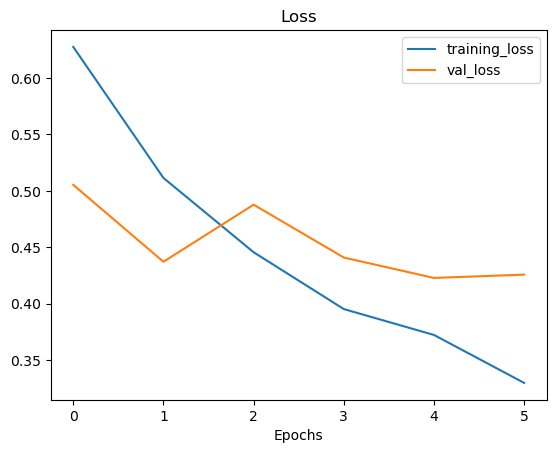

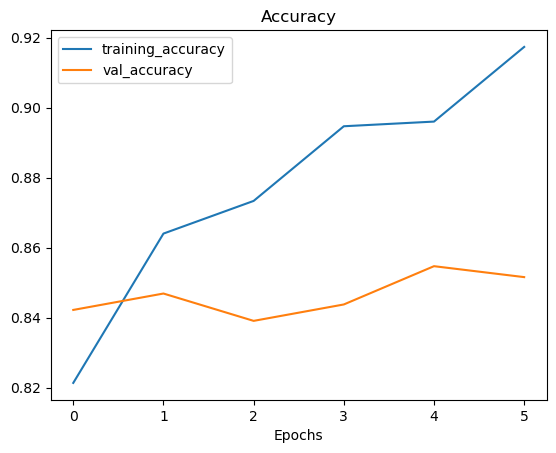

In [49]:
# check out loss curves of fine-tuned
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once. We need a function that will compare histories when the model is trained for more epochs

In [50]:
# Create function 
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History Objects
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    # combine original history with new history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    
    # make plots for accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    
    # make plots for loss
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Accuracy")

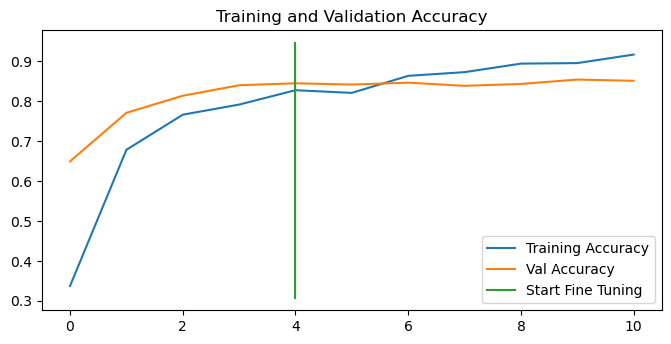

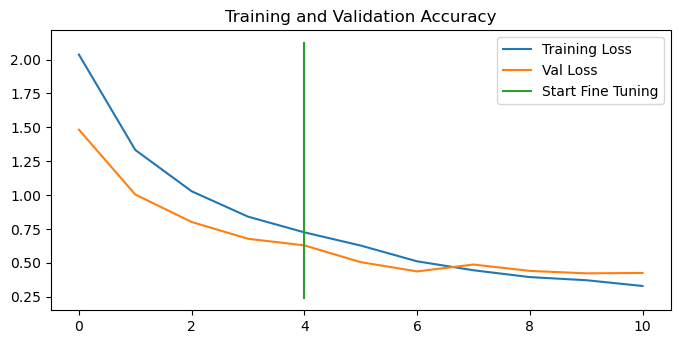

In [51]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data

In [52]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 


--2023-01-10 23:23:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.16, 142.251.35.208, 172.217.1.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.2’

10_food_classes_all 100%[===================>] 495.13M   108MB/s    in 4.8s    

2023-01-10 23:23:50 (103 MB/s) - ‘10_food_classes_all_data.zip.2’ saved [519183241/519183241]



In [53]:
unzip_data("10_food_classes_all_data.zip")

In [54]:
# setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [55]:
# how many images per class
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 

In [56]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE=(224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [57]:
# evaluate model 2 (this is the fine-tuned on 10 percent)
model_2.evaluate(test_data)

79/79 [==============================] - 3s 33ms/step - loss: 0.4077 - accuracy: 0.8636


[0.4076552987098694, 0.8636000156402588]

To train a fine-tuning model we need to rever model_2 back to it's feature extraction weights.

In [58]:
# load weights from checkpoint
model_2.load_weights(checkpoint_path)

In [59]:
# Evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 3s 33ms/step - loss: 0.6305 - accuracy: 0.8512


[0.6305294632911682, 0.8512000441551208]

In [60]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_aug_data

[0.6305296421051025, 0.8512000441551208]

In [61]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [63]:
# Let's look into efficientnet (base_model)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer.name, layer.trainable)

input_3 False
rescaling_4 False
normalization_2 False
rescaling_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [64]:
# compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(.0001),
                metrics=["accuracy"])

In [69]:
# fit to all 100% of data
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps=len(test_data),
                                          initial_epoch=history_10_percent_data_aug.epoch[-1],
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230110-233345
Epoch 5/10


2023-01-10 23:33:49.417260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:33:50.243632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:33:50.243701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:33:50.243749: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:33:50.244350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

235/235 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.7884

2023-01-10 23:37:27.816487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 23:37:28.170442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 23:37:28.170490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 83006 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-01-10 23:37:28.170536: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-10 23:37:28.171014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identi

235/235 [==============================] - 225s 938ms/step - loss: 0.6543 - accuracy: 0.7884 - val_loss: 0.3723 - val_accuracy: 0.8776
Epoch 6/10
235/235 [==============================] - 211s 899ms/step - loss: 0.5339 - accuracy: 0.8277 - val_loss: 0.3275 - val_accuracy: 0.8940
Epoch 7/10
235/235 [==============================] - 213s 905ms/step - loss: 0.4759 - accuracy: 0.8473 - val_loss: 0.3160 - val_accuracy: 0.8968
Epoch 8/10
235/235 [==============================] - 212s 904ms/step - loss: 0.4142 - accuracy: 0.8665 - val_loss: 0.2854 - val_accuracy: 0.9060
Epoch 9/10
235/235 [==============================] - 212s 903ms/step - loss: 0.3966 - accuracy: 0.8681 - val_loss: 0.2858 - val_accuracy: 0.9056
Epoch 10/10
235/235 [==============================] - 212s 900ms/step - loss: 0.3616 - accuracy: 0.8844 - val_loss: 0.2661 - val_accuracy: 0.9120


In [70]:
# evaluate on all of test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 3s 35ms/step - loss: 0.2661 - accuracy: 0.9120


[0.2660652697086334, 0.9120000600814819]

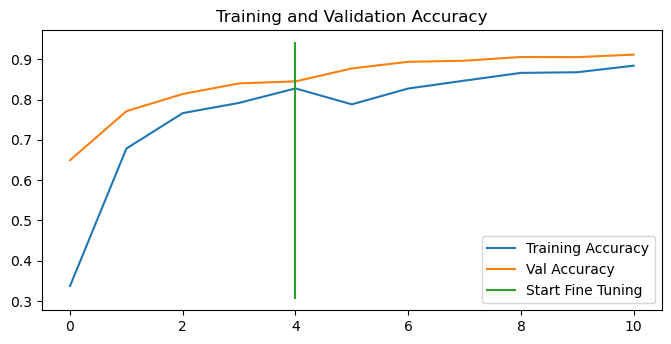

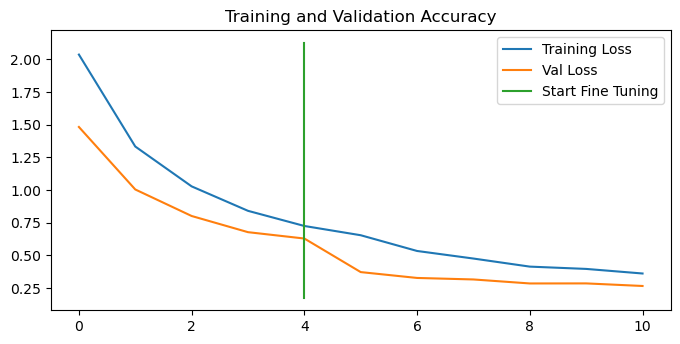

In [72]:
# How did fine-tuning go with more data
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full,
                  initial_epochs=5)

## Viewing our experiment data on TensorBoard

In [73]:
# View tensorboard logs of transfer learning modeling experiments
# upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 Classes" \
    --description "A series of transfer learning experiements for food vision" \
    --one_shot

2023-01-11 00:08:19.048682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 00:08:19.785618: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-01-11 00:08:19.785671: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-01-11 00:08:19.787815: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-01-11 00:08:20.070304: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/PdBWuRPtRmmbPyR9eGry4A/

[2023-01-11T00:08:21] Started scanning logdir.
[20